<div style="background-color: #00FF00; padding: 20px;">
    <p style='text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:black;
              font-size:50px;
              margin: 5px;'> 
        <font color='blue'; size='7'>Price Forecasting</font>
    </p>
    <p style="text-align:center;
              font-family: sans-serif;
              font-weight:bold;
              color:tomato;
              font-size:40px;
              margin: 10px;">
        SARIMA Model
    </p>
</div>

<h1 style="text-align: center; color: WHITE; font-size:30px; background-color: #00FF00; padding: 10px; border-radius: 5px;">
    Project Workflow
</h1>

### 1. Get Data
   - Load your time series data.

### 2. Set Date as Index
   - Ensure the date column is set as the index of the DataFrame.

### 3. Plot and Test for Stationarity
   - Use visual plots and perform the Dickey-Fuller test to check stationarity.

### 4. Remove Non-Stationary Nature
   - Apply transformations or differencing to address non-stationarity.

### 5. Remove Seasonality Nature
   - Use seasonal decomposition to remove seasonal effects.

### 6. Check Stationarity Again
   - Re-check stationarity after removing non-stationary and seasonal components.

### 7. Plot ACF and PACF
   - Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify SARIMA parameters.

### 8. Model Selection
   - Choose the SARIMA model based on the ACF and PACF plots.

### 9. Fit the Model
   - Train the SARIMA model on your time series data.

### 10. Obtain Model Diagnostics
    - Analyze diagnostics to validate the model fit.

### 11. Forecasting
    - Create a DataFrame with actual and predicted values, and save it as `SARIMA.csv`.

### 12. Evaluate Forecast Accuracy
    - Assess the accuracy of your forecasts using appropriate metrics.s.</li>
</ol>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

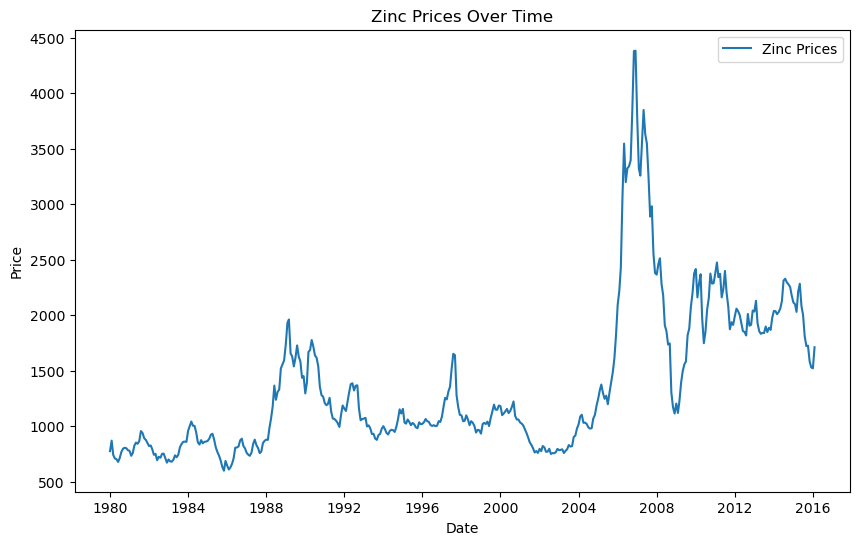

In [2]:
# Step 1: Get Data
file_path = 'zinc_prices_IMF.csv'  # Replace with your file path
zinc_prices = pd.read_csv(file_path)

# Step 2: Set Date as index and convert to datetime
zinc_prices['Date'] = pd.to_datetime(zinc_prices['Date'])
zinc_prices.set_index('Date', inplace=True)

# Step 3: Plot and test for stationarity with Dickey-Fuller Test
plt.figure(figsize=(10, 6))
plt.plot(zinc_prices, label='Zinc Prices')
plt.title('Zinc Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [3]:
# Perform Augmented Dickey-Fuller (ADF) Test for Stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
        
adf_test(zinc_prices['Price'])

ADF Statistic: -3.139600554153094
p-value: 0.023758021886102005
Critical Values:
   1%, -3.4457939940402107
Critical Values:
   5%, -2.8683485906158963
Critical Values:
   10%, -2.570396746236417


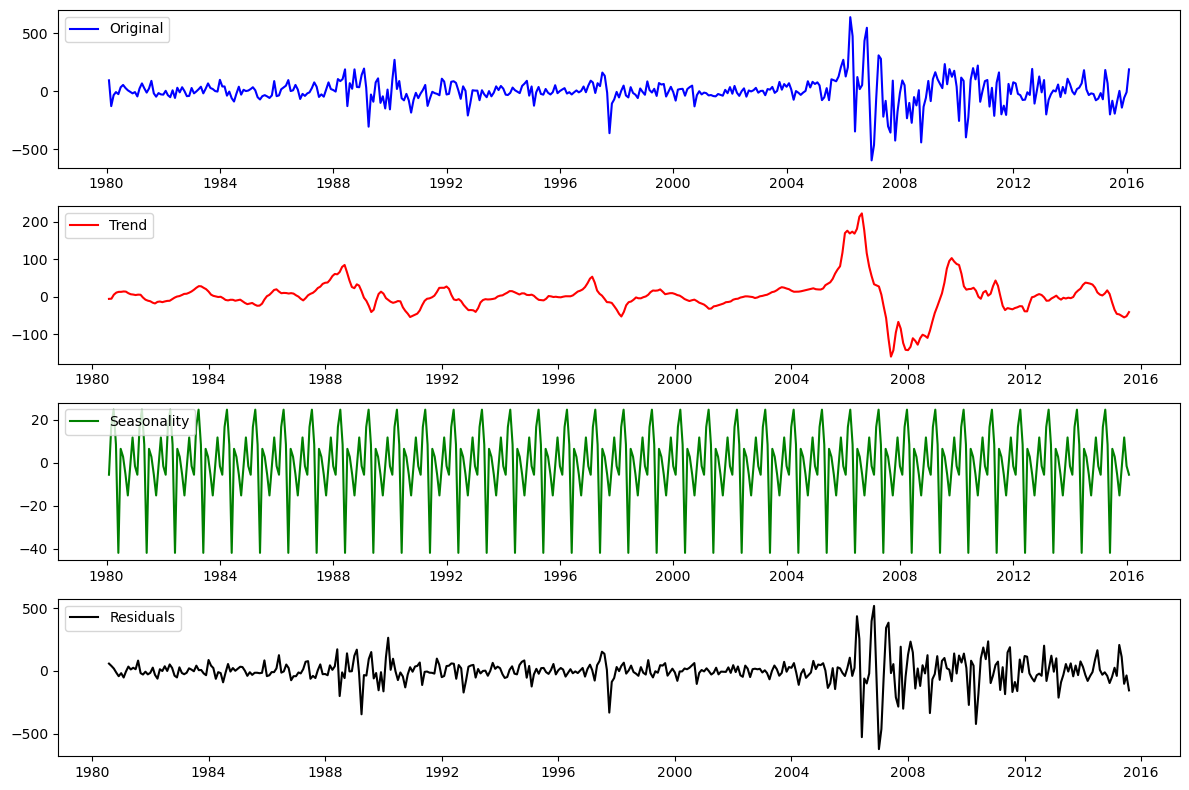

In [4]:
# Step 4: Remove Non-Stationary Nature (Differencing)
zinc_prices_diff = zinc_prices.diff().dropna()

# Step 5: Remove Seasonality Nature (Decomposition)
decomposition = seasonal_decompose(zinc_prices_diff, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(zinc_prices_diff, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='black')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
# Step 6: Check Stationarity Again
adf_test(residual.dropna())

ADF Statistic: -9.203283649152535
p-value: 1.9755263295875877e-15
Critical Values:
   1%, -3.446599953548936
Critical Values:
   5%, -2.86870295908671
Critical Values:
   10%, -2.570585643956714


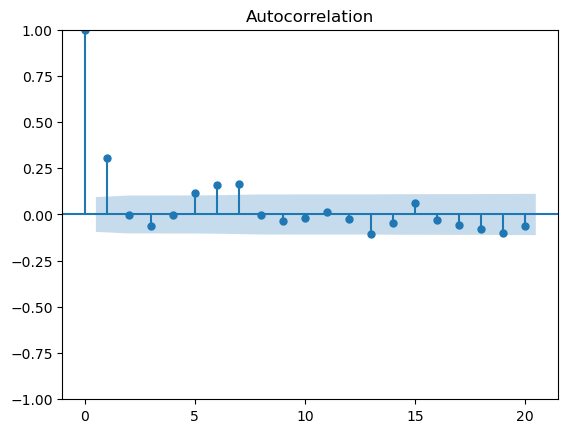

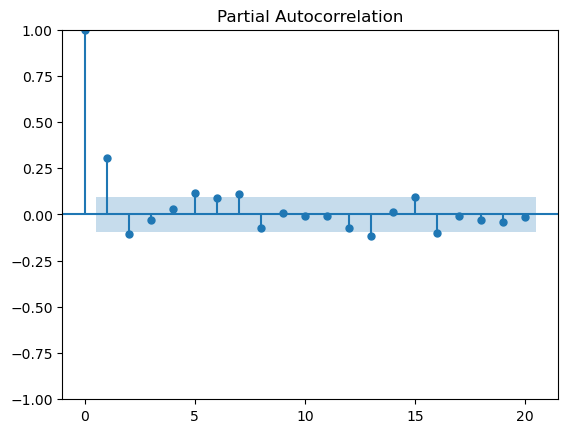

In [6]:
# Step 7: Plot ACF and PACF: Identify parameters for SARIMA models
plot_acf(zinc_prices_diff, lags=20)
plt.show()

plot_pacf(zinc_prices_diff, lags=20)
plt.show()

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def expanding_window_forecast(data, initial_train_size, order, seasonal_order):
    """
    Perform expanding window forecast using SARIMA model with diagnostics.

    Parameters:
    -----------
    data : pandas.Series
        The time series data to be used for forecasting.
    initial_train_size : int
        The number of initial data points to be used for training the model.
    order : tuple
        The (p, d, q) order of the non-seasonal component of the SARIMA model.
    seasonal_order : tuple
        The (P, D, Q, s) order of the seasonal component of the SARIMA model.

    Returns:
    --------
    predictions : list
        The list of predictions made by the model for the test set.
    test : pandas.Series
        The actual values from the test set.
    """
    history = list(data[:initial_train_size])
    test = data[initial_train_size:]
    predictions = []
    
    for t in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        # Model diagnostics for each expanding window fit
        print(f"Expanding Window Step {t+1}:")
        print(f"AIC: {model_fit.aic}")
        print(f"BIC: {model_fit.bic}")
        print(f"Log-Likelihood: {model_fit.llf}")
        print("-----")
        
        forecast = model_fit.forecast(steps=1)[0]
        predictions.append(forecast)
        history.append(test[t])
    
    return predictions, test

# Example usage
initial_train_size = int(len(zinc_prices) * 0.8)
order = (1, 1, 1)  # Adjust based on ACF/PACF plots
seasonal_order = (1, 1, 1, 12)  # Adjust based on seasonal pattern and data frequency

# Fit the Model
predictions, test = expanding_window_forecast(zinc_prices['Price'], initial_train_size, order, seasonal_order)


Expanding Window Step 1:
AIC: 4102.390032569105
BIC: 4121.445737533988
Log-Likelihood: -2046.1950162845524
-----
Expanding Window Step 2:
AIC: 4113.968994876819
BIC: 4133.039647535945
Log-Likelihood: -2051.9844974384096
-----
Expanding Window Step 3:
AIC: 4126.455194820821
BIC: 4145.540750620637
Log-Likelihood: -2058.2275974104105
-----
Expanding Window Step 4:
AIC: 4139.27478718531
BIC: 4158.3752018370715
Log-Likelihood: -2064.637393592655
-----
Expanding Window Step 5:
AIC: 4151.876231650173
BIC: 4170.991461127588
Log-Likelihood: -2070.9381158250867
-----
Expanding Window Step 6:
AIC: 4164.062914218223
BIC: 4183.1929147551255
Log-Likelihood: -2077.0314571091117
-----
Expanding Window Step 7:
AIC: 4175.2991645506545
BIC: 4194.443892638706
Log-Likelihood: -2082.6495822753272
-----
Expanding Window Step 8:
AIC: 4187.16922170402
BIC: 4206.328634090438
Log-Likelihood: -2088.58461085201
-----
Expanding Window Step 9:
AIC: 4198.339083042525
BIC: 4217.513136727838
Log-Likelihood: -2094.16954

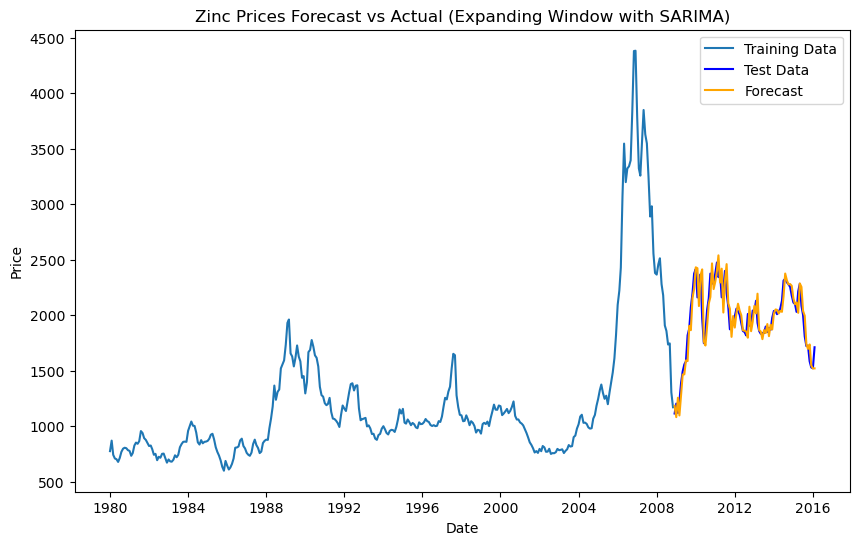

Mean Absolute Error: 93.99486908371546
Mean Squared Error: 15672.77328334756
Root Mean Squared Error: 125.19094728992013
Results saved to Expanding_SARIMA.csv


In [8]:
# Step 11: Forecasting: Create a dataframe with y_test and y_pred and save it as SARIMA.csv
results_df = pd.DataFrame({
    'Date': zinc_prices.index[initial_train_size:],
    'y_test': test,
    'y_pred': predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv('Expanding_SARIMA.csv', index=False)

# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(zinc_prices.index[:initial_train_size], zinc_prices['Price'][:initial_train_size], label='Training Data')
plt.plot(results_df['Date'], results_df['y_test'], label='Test Data', color='blue')
plt.plot(results_df['Date'], results_df['y_pred'], label='Forecast', color='orange')
plt.title('Zinc Prices Forecast vs Actual (Expanding Window with SARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 12: Evaluate Forecast Accuracy
mae = mean_absolute_error(results_df['y_test'], results_df['y_pred'])
mse = mean_squared_error(results_df['y_test'], results_df['y_pred'])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

print("Results saved to Expanding_SARIMA.csv")
